# Моделирование роста монокристаллического твердого раствора $Al_xGa_{1-x}N$ методом хлоридной эпитаксии


## Сазанович Владислав М3339

In [1]:
import numpy as np
import pandas as pd
import scipy as sp
import scipy.linalg
import sympy as sm
from tqdm import tqdm
from ggplot import *

In [2]:
# Для тестов
def is_close(a, b, rel_tol=1e-06, abs_tol=0.0):
    return abs(a-b) <= max(rel_tol * max(abs(a), abs(b)), abs_tol)

In [3]:
row_data = pd.read_csv('q.csv', sep=';', 
                       index_col=False, 
                       names=["", "Phase", "T1", "T2", "H", "f1", "f2", "f3", "f4", "f5", "f6", "f7", 
                              "mu", "sigma", "epsil", "Comment"])
row_data.set_index('', inplace = True)
row_data

,Phase,T1,T2,H,f1,f2,f3,f4,f5,f6,f7,mu,sigma,epsil,Comment
,,,,,,,,,,,,,,,
AlCl,g,298.15,3000.00,-51032.0,318.9948,36.946260,-0.001226,1.188174,5.638541,-5.066135,5.219347,62.4345,3.580,932.00,"1,2"
AlCl2,g,298.15,3000.00,-259000.0,427.2137,56.564090,-0.002961,1.893842,12.400720,-22.654410,21.298980,97.8875,5.300,825.00,"1,2,55"
AlCl3,g,298.15,3000.00,-584100.0,511.8114,81.150420,-0.004835,2.752097,13.400780,-21.280010,16.928680,133.3405,5.130,472.00,"1,2"
GaCl,g,298.15,3000.00,-70553.0,332.2718,37.110520,-0.000746,1.160651,4.891346,-4.467591,5.506236,105.1730,3.696,348.20,1
GaCl2,g,298.15,3000.00,-241238.0,443.2976,57.745845,-0.002265,1.875554,3.661860,-9.356338,15.882450,140.6260,4.293,465.00,1
GaCl3,g,298.15,3000.00,-431573.0,526.8113,82.033550,-0.003486,2.685592,8.278878,-14.567800,12.889900,176.0800,5.034,548.24,1
NH3,g,298.15,3000.00,-45940.0,231.1183,20.522220,0.000716,0.767724,244.629600,-251.690000,146.694700,17.0310,3.000,300.00,"26,1"
H2,g,298.15,3000.00,0.0,205.5368,29.504870,0.000168,0.860656,-14.953120,78.189550,-82.789810,2.0160,2.930,34.10,"4,1"
HCl,g,298.15,3000.00,-92310.0,243.9878,23.159840,0.001820,0.614738,51.166040,-36.895020,9.174252,36.4610,2.737,167.10,1


Так можно брать данные из строчки по имени:

In [4]:
print(row_data.loc['AlCl'].f1)

318.9948


In [5]:
# Constants
R = 8314 # Дж/(кмоль*К)

# Распределение веществ по твердым, жидким и газообазным
solid = {'Al', 'AlN', 'GaN'}
liquid = {'Ga'}
gas = {'AlCl', 'AlCl2', 'AlCl3', 'GaCl', 'GaCl2', 'GaCl3', 'NH3', 'H2', 'HCl', 'N2'}

In [6]:
""" Коэффициенты диффузии (м2/сек) для газообразных компонент
ind - 'AlCl', 'GaN, ... 
t - температура в К
p - полное давление в системе
"""
def calcDGas(ind, t, p):
    assert (ind in gas), "This function could caclulate D only for gaseous substance"
    
    numerator = 2.628 * 10**(-2) * t**(3/2)
    
    d_ind = row_data.loc[ind]
    d_N2 = row_data.loc['N2']
    
    sigma = (d_ind.sigma + d_N2.sigma) / 2
    epsil = (d_ind.epsil * d_N2.epsil)**(1/2)
    mu = (2 * d_ind.mu * d_N2.mu) / (d_ind.mu + d_N2.mu)
    omega = 1.074 * (t / epsil)**(-0.1604)
    
    return numerator / (p * omega * mu**(1/2))


"""
Φ для расчета энергии Гиббса
ind - 'AlCl', 'GaN, ... 
t - температура в К
"""
def calcPhi(ind, t):
    data = row_data.loc[ind]
    x = t / 10**4
    
    return data.f1 + data.f2 * np.log(x) + data.f3 / x**2 + data.f4 / x + data.f5 * x + data.f6 * x**2 + data.f7 * x**3
   
    
"""
Энергия Гиббса
ind - 'AlCl', 'GaN, ... 
t - температура в К
"""
def calcG(ind, t):
    data = row_data.loc[ind]
    return data.H - calcPhi(ind, t) * t

Pa = 100000 # атмосферное давление


def calcK1(t):
    deltaG1 = 2 * calcG('Al', t) + 2 * calcG('HCl', t) - 2 * calcG('AlCl', t) - calcG('H2', t)
    return np.exp(-deltaG1 / (R * t)) / Pa


def calcK2(t):
    deltaG2 = calcG('Al', t) + 2 * calcG('HCl', t) - calcG('AlCl2', t) - calcG('H2', t)
    return np.exp(-deltaG2 / (R * t))


def calcK3(t):
    deltaG3 = calcG('Al', t) - 2 * calcG('AlCl3', t) - 3 * calcG('H2', t) + 6 * calcG('HCl', t)
    return np.exp(-deltaG3 / (R * t)) * Pa

# Первое задание

In [7]:
"""
Парциальные давления компонент вне диффузионного пограничного слоя (Па)
PS Даны в условии поэтому дефайним только для этого задания
ind - 'AlCl', 'GaN, ... 
"""
def calcPg(ind):
    if ind == 'AlCl' or ind == 'AlCl2' or ind == 'AlCl3' or ind == 'H2':
        return 0
    if ind == 'HCl':
        return 10000
    if ind == 'N2':
        return 90000
    raise Exception('Unexpected substance: ' + ind)


def first_task():
    P = 100000 # Па
    print(calcDGas('AlCl', 400, P))
    
# просто проверить что работает
first_task()
calcK1(100)
calcK2(100)
calcK3(100)
calcPg('AlCl')
calcPg('HCl')
calcPg('N2')

0.00033771956183


90000

In [8]:
def make_system(pg_HCl=10000.0, p=100000, T=(350.0 + 273.0)):
    p_AlCl, p_AlCl2, p_AlCl3, p_HCl, p_H2 = variables = sm.symbols('p_AlCl, p_AlCl2, p_AlCl3, p_HCl, p_H2')
    k1 = calcK1(T)
    k2 = calcK2(T)
    k3 = calcK3(T)
    d_HCl = calcDGas('HCl', T, p)
    d_H2 = calcDGas('H2', T, p)
    d_AlCl = calcDGas('AlCl', T, p)
    d_AlCl2 = calcDGas('AlCl2', T, p)
    d_AlCl3 = calcDGas('AlCl3', T, p)
    equations = []
    equations.append(p_HCl ** 2 - k1 * p_AlCl ** 2 * p_H2)
    equations.append(p_HCl ** 2 - k2 * p_AlCl2 * p_H2)
    equations.append(p_HCl ** 6 - k3 * p_AlCl3 ** 2 * p_H2 ** 3)
    equations.append(d_HCl * p_HCl + 2 * d_H2 * p_H2)
    equations.append(d_AlCl  * p_AlCl  + 
                 2 * d_AlCl2 * p_AlCl2 + 
                 3 * d_AlCl3 * p_AlCl3 + 
                     d_HCl * (p_HCl - pg_HCl))
    system = sm.Matrix(equations)
    jacobian = system.jacobian(variables)
    system = sm.lambdify(variables, system)
    jacobian = sm.lambdify(variables, jacobian)
    return system, jacobian, variables

In [9]:
def newton_solve(T, epsilon=1e-12):
    system, jacobian, variables = make_system(T=T)
    # TODO: think about gaussian std
    x = np.random.normal(0., 1., 5).tolist()
    delta = 1
    nstep = 0
    while np.linalg.norm(delta) > epsilon:
        delta = sp.linalg.lu_solve(sp.linalg.lu_factor(jacobian(*x)), -system(*x))
        x = delta.flatten() + x
        nstep += 1
    # evaluate error: residual sum of absulute values F(x)
    rsa = np.abs(system(*x.tolist())).sum()
    return x, rsa, nstep

In [10]:
print('One of solutions:')
system, jacobian, variables = make_system(350 + 273)
dict(zip(variables, newton_solve(350 + 273)[0]))

One of solutions:


{p_HCl: -1.140240036432882e-35,
 p_AlCl3: 4379.4246395398231,
 p_AlCl: 1.5550110170722562e-12,
 p_H2: 1.7292643853832328e-36,
 p_AlCl2: 7.6431796969642349e-35}

In [11]:
# benchmark
Ts = np.linspace(350, 650, 60) + 273
nruns = 10
sigma = 0.01
p = calcPg('HCl') + calcPg('N2')
newton_benchmark = pd.DataFrame(columns=['T_', 'V_Al', 'G_AlCl', 'G_AlCl2', 'G_AlCl3', 
                                         'rsa', 'rsa_std', 'nstep', 'nstep_std'])
targets = ['AlCl', 'AlCl2', 'AlCl3']
for k, T in tqdm(list(enumerate(Ts))):
    sols = np.zeros((nruns, 5))
    rsa = np.zeros(nruns)
    nstep = np.zeros(nruns)
    for i in range(nruns):
        sols[i], rsa[i], nstep[i] = newton_solve(T)
    sol_std = sols.std(0)
    solution = sols.mean(0)
    rsa_std = rsa.std()
    rsa = rsa.mean()
    nstep_std = nstep.std()
    nstep = nstep.mean()
    # G_i
    G = {}
    Pe = dict(zip(map(str, variables), solution))
    for Gas in targets:
        G[Gas] = calcDGas(Gas, T, p) * (calcPg(Gas) - Pe['p_' + Gas]) / (R * T * sigma)
    pho = 2712.0
    mu = row_data.loc['Al'].mu
    V = (G['AlCl'] + G['AlCl2'] + G['AlCl3']) * (mu / pho) * 1e9
    newton_benchmark.loc[k] = {
        'T_': T,
        'V_Al': V,
        'G_AlCl': G['AlCl'],
        'G_AlCl2': G['AlCl2'],
        'G_AlCl3': G['AlCl3'],
        'rsa': rsa,
        'rsa_std': rsa_std,
        'nstep': nstep,
        'nstep_std': nstep_std
    }

100%|██████████| 60/60 [00:18<00:00,  3.34it/s]


In [12]:
newton_benchmark

,T_,V_Al,G_AlCl,G_AlCl2,G_AlCl3,rsa,rsa_std,nstep,nstep_std
0,623.000000,-572.239493,2.240130e-21,-1.500229e-37,-0.000058,7.322595e-16,8.961423e-17,104.3,3.287856
1,628.084746,-575.319601,-1.657674e-20,-1.770464e-37,-0.000058,6.324075e-16,1.194735e-16,107.8,12.757743
2,633.169492,-578.391253,7.304768e-21,4.989007e-38,-0.000058,5.986886e-16,2.035661e-16,106.1,7.879721
3,638.254237,-581.454539,-1.242642e-20,3.072535e-38,-0.000058,1.776357e-16,5.329071e-16,103.3,3.494281
4,643.338983,-584.509548,-1.265273e-20,1.285669e-40,-0.000059,6.251449e-16,1.860609e-16,103.1,3.144837
5,648.423729,-587.556369,-9.606032e-21,2.278220e-41,-0.000059,4.860704e-16,1.363925e-16,103.1,3.910243
6,653.508475,-590.595086,-1.915712e-20,4.576599e-40,-0.000059,5.141353e-16,1.594639e-16,103.3,1.345362
7,658.593220,-593.625785,-1.123927e-20,-1.773751e-37,-0.000060,3.552714e-16,1.065814e-15,104.6,2.457641
8,663.677966,-596.648547,-4.319313e-21,1.411985e-39,-0.000060,1.776357e-15,1.375960e-15,105.2,2.638181
9,668.762712,-599.663455,-3.915371e-21,4.686387e-39,-0.000060,9.207211e-16,7.487379e-16,110.0,24.730548


In [39]:
newton_benchmark['invT'] = 1 / newton_benchmark.T_
newton_benchmark['V_Al_log'] = np.log(np.abs(newton_benchmark.V_Al))
newton_benchmark['G_AlCl_log'] = np.log(np.abs(newton_benchmark.G_AlCl))
newton_benchmark['G_AlCl2_log'] = np.log(np.abs(newton_benchmark.G_AlCl2))
newton_benchmark['G_AlCl3_log'] = np.log(np.abs(newton_benchmark.G_AlCl3))
newton_df = pd.melt(newton_benchmark[['invT', 'V_Al_log', 'G_AlCl_log', 
                                      'G_AlCl2_log', 'G_AlCl2_log', 'G_AlCl3_log']], id_vars=['invT'])

/usr/local/lib/python3.5/dist-packages/ggplot/stats/stat_smooth.py:77: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  smoothed_data = smoothed_data.sort('x')


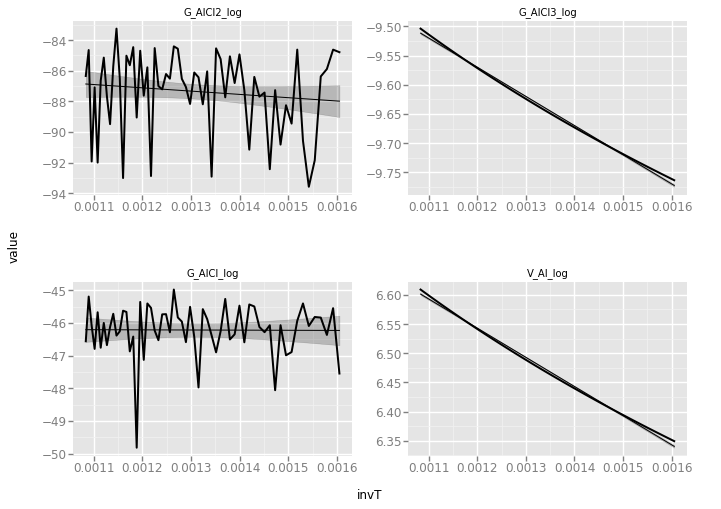

<ggplot: (8746317912538)>

In [52]:
ggplot(aes(x = 'invT', y = 'value'), newton_df) + \
    geom_line(size=2, f='red') + \
    stat_smooth(method='lm') + \
    facet_wrap('variable', scales='free')